# Alignment of SMP and Snow Pits / Evaluation of Proksch (P15) coefficients
*Josh King, Environment and Climate Change Canada, 2019*

This workbook introduces a snow on sea ice calibration procedures for SMP derived estimates of density first introduced in [Proksch, et al., 2015](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2014JF003266). The work modifies portions of the [SMP python package from SLF](https://github.com/slf-dot-ch/snowmicropyn) where indicated and uses a number of open source community packages to facilitate processing.

I'm still not great at GIS in python so the maps in the publication were done in ESRI ArcMap.

Alignment takes a long time before of the large number of scaling candidates. If you want to skip that part and just load the result set `skip_alignment` as `True`.

### Notes on settings and constants
**CUTTER_SIZE** defines the half height of the density cutter used as reference in mm. Can be changed to accommodate different sampler sizes. No need to change this for ECCC data. 

**WINDOW_SIZE** defines the size of rolling window used in the SLF shot noise calculations. A 5 mm window was used in [Proksch, et al., 2015](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2014JF003266) when there was separation between the SMP and density cutter. Increasing the window reduces sensitivity to sharp transitions and reduces resolution of the analysis. However, moving to something like 2.5 mm makes comparison difficult as some of the very fine structure resolved as very different over the ~10 cm separation between the SMP and density profiles. 

**NUM_TESTS** defines how many random scaling configurations to test against when attempting to alignment the SMP and snow pit data. We brute-force the alignment in our paper so NUM_TESTS must be large to ensure the test space searched is sufficient. A lower number of tests risks poor alignment and therefore poor calibration. In the paper we use 10k permutations.

**MAX_STRETCH_LAYER** and **MAX_STRETCH_OVERALL** define how much an individual layer can be eroded or dilated, and the maximum change in total length of the SMP profile, respectively. We allow a rather large 70% change to individual layers to accommodate pinching out but restrict the total change to 10% to avoid overfitting.

**H_RESAMPLE** and **L_RESAMPLE** define the resampled resolution of the SMP and the layer size used for matching profiles. These terms are interactive with the layer stretching and should be evaluted carefully if changed.


In [1]:
# Community packages
import os 
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from scipy import stats
from statsmodels.formula.api import ols

from matplotlib import pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

# Local packages
import smpfunc # SMP helper functions

# Import SLF SMP Package
from snowmicropyn import Profile, proksch2015, loewe2012

# Import data
pit_summary = pd.read_csv("./data/Pit/pit_summary.csv")
pit_density = pd.read_csv("./data/Pit/pit_density.csv")
input_data = os.path.abspath("./data/SMP/Calibration")

# Set constants
CUTTER_SIZE = 15  # Half the height of the density cutter in mm
WINDOW_SIZE = 5  # SMP analysis window in mm
H_RESAMPLE = 1  # Delta height in mm for standardized SMP profiles
L_RESAMPLE = 50  # Layer unit height in mm for SMP matching
MAX_STRETCH_LAYER = 0.75  # Max layer change in % of height
MAX_STRETCH_OVERALL = 0.15  # Max profile change in % of total height
NUM_TESTS = 10000  # Number of scaling candidates to generate for alignment testing 

# Set conditions
skip_alignment = False # Set as true to just load the results from a pickle instead of reprocessing
paper_conditions = True # Set as true to reproduce the paper results with seeding

# Small differences in comparison to the paper will occur if a seed is not set.
# This is mainly because we use a brute-force approach to matching the smp and 
# snow pit profiles with modest search size (specified by NUM_TESTS).
if paper_conditions:
    np.random.seed(2019) 

os.makedirs('./output/figures', exist_ok=True)    
    
def rmse(data):
    return np.sqrt(np.mean(data**2))

In [2]:
# Load the SMP calibration profiles, should be 25 for the ECCC case
# Preprocess the files to remove noise and detect interfaces
def load_smp(smp_file):
    p = Profile.load(smp_file)
    p = smpfunc.preprocess(p, smoothing = 0, noise_threshold = 0.01)
    ground  = p.detect_ground()
    surface  = p.detect_surface()
    return p

file_list = []
for file in os.listdir(input_data):
    if file.endswith(".pnt"):
        file_list.append(os.path.join(input_data, file))
        
smp_data = [load_smp(file) for file in file_list]

print("SMP calibration profiles loaded: {}".format(len(smp_data)))

SMP calibration profiles loaded: 25


### Summary information on the snow pit properties

**pit_summary** holds summary information on all now pits here is a breakdown of the variables within  
**ID**: Paper site identification code  
**IOP**: Campaign identity code where a = Alert and e = Eureka  
**ICE**: Ice surface type where m = MYI and f = FYI  
**DOY**: Day of year  
**Date**: Date snow pit was completed  
**SITEID**: Campaign specific site identification code  
**LAT** and **LON** decimal degree WGS-84 coordinates  
**PITFILE**: Internal ECCC snow pit file names (Available on request)  
**SMPF**: Last 4 digits of the corresponding SMP file name  
**MPD** Average of nearby Magnaprobe measured snow thickness  
**SD**: Total snow pit thickness  
**PD**: Operator recoded SMP penetration, better to check directly from SMPF  
**OFF**: Offset between retracted SMP tip and the snow surface. When mounted on the support structure this generally does not change unless there is settling  
**NOTESMP**: SMP operator notes  
**NOTESPIT**: Snow pit operator notes  


In [3]:
pit_summary.head(1)

,ID,IOP,ICE,DOY,Date,SITEID,LAT,LON,PITFILE,SMPF,MPD,SD,PD,OFF,NOTESMP,NOTESPIT
0,1,a,m,101,11/04/2017,3,83.98343,-66.35089,170411_Site3_Pit1,1848,0.52,0.45,0.6,0.16,Probe went down fine. Tilted forward a few deg...,Completed ~100 m away from the aircraft landin...


In [4]:
print('SMP profile total: %i' % len(smp_data))
print('Snow pit total: %i' % len(pit_summary))
print('\nDensity total: %i' % len(pit_density))
print('\nSnow pits by campaign:')
print(pit_summary.IOP.value_counts())
print('\nSnow pits by ice type:')
print(pit_summary.ICE.value_counts())

# Note: The small number of recent snow measurements were rolled into rounded classification
#       for the paper. In the future many more measurements are needed to chracterize recent snow

print('\nDensity measurements by layer type:')
print(pit_density.TYPE.value_counts())

SMP profile total: 25
Snow pit total: 25

Density total: 219

Snow pits by campaign:
e    20
a     5
Name: IOP, dtype: int64

Snow pits by ice type:
f    17
m     8
Name: ICE, dtype: int64

Density measurements by layer type:
F    88
H    86
R    36
I     6
N     3
Name: TYPE, dtype: int64


### Extraction of corresponding snow pit density and SMP properties
This section relies on functions imported from `smpfunc.py`. We iterate through all the SMP profiles that are associated with snow pits and do the following:

1. Restructure the snow pit density estimates into a dataframe (`density_df`)  
2. Make first guess estimates of density using the P15 coefficients (`p2015`)  
3. Resample the SMP and snow pit arrays to a common thickness axis  
4. Generate scaling candidates (`random_tests`) according to `L_RESAMPLE`, `NUM_TESTS`, `MAX_STRETCH_OVERALL`, and `MAX_STRETCH_LAYER` 
5. Scale the profiles and extract the SMP estimates corresponding with each density cutter measurement (`compare_profiles`)  
6. Evaluate retrieval skill according to correlation and rmse (`retrieved_skill`)  
7. Save properties of the best scaling candidate for further analysis  

In [5]:
comparison_df = pd.DataFrame()
min_scaling_coeff = []
if not skip_alignment:
    for smp in smp_data:
        smp_file_num = int(smp.name[-4:])
        pit_df  = pit_summary[pit_summary['SMPF'] == smp_file_num] # Select the matching pit
        density_df = pit_density[pit_density['ID'] == pit_df['ID'].values[0]]
        density_df = density_df.assign(relative_height=np.abs(((density_df['TOP']*10) - CUTTER_SIZE) - density_df['TOP'].max()*10).values)

        # Make first guess at microstructure based on original profile
        l2012 = loewe2012.calc(smp.samples_within_snowpack(), window=WINDOW_SIZE)
        p2015 = proksch2015.calc(smp.samples_within_snowpack(), window=WINDOW_SIZE)

        # Estimate offset of the snow depth and SMP profile
        smp_profile_height = p2015.distance.max()
        smp_height_diff = pit_df.MPD.values*1000 - smp_profile_height

        # Create new SMP resampled arrays and determine the number of layers
        depth_array = np.arange(0, p2015.distance.max() + smp_height_diff, H_RESAMPLE)
        density_array = np.interp(depth_array,p2015.distance,p2015.P2015_density)
        force_array = np.interp(depth_array,p2015.distance,l2012.force_median)
        l_array = np.interp(depth_array,p2015.distance,l2012.L2012_L)

        smp_df = pd.DataFrame({'distance': depth_array, 
                               'density': density_array,
                               'force_median': force_array,
                               'l': l_array})

        # Generate a selection of random transformation to brute-force alignment
        # We use this brute force approach because there was no gradient that could be used to optimize the relationship
        num_sections = np.ceil(len(smp_df.index)/L_RESAMPLE).astype(int)
        random_tests = [smpfunc.random_stretch(x, MAX_STRETCH_OVERALL, MAX_STRETCH_LAYER) for x in np.repeat(num_sections, NUM_TESTS)] 

        scaled_profiles = [smpfunc.scale_profile(test, smp_df.distance.values, smp_df.density.values, L_RESAMPLE, H_RESAMPLE) for test in random_tests]
        compare_profiles = [smpfunc.extract_samples(dist, rho, density_df.relative_height.values, CUTTER_SIZE) for dist, rho in scaled_profiles]
        compare_profiles = [pd.concat([profile, density_df.reset_index()], axis=1, sort=False) for profile in compare_profiles]
        retrieved_skill = [smpfunc.calc_skill(profile, CUTTER_SIZE) for profile in compare_profiles]
        retrieved_skill = pd.DataFrame(retrieved_skill,columns = ['r','rmse','rmse_corr','mae'])

        min_scaling_idx = retrieved_skill.sort_values(['r', 'rmse_corr'], ascending=[False, True]).head(1).index.values
        min_scaling_coeff.append(random_tests[int(min_scaling_idx)])
        
        dist, scaled_l =  smpfunc.scale_profile(min_scaling_coeff[-1], smp_df.distance.values, smp_df.l.values, L_RESAMPLE, H_RESAMPLE)
        dist, scaled_force_median = smpfunc.scale_profile(min_scaling_coeff[-1], smp_df.distance.values, smp_df.force_median.values, L_RESAMPLE, H_RESAMPLE)

        result = compare_profiles[int(min_scaling_idx)].assign(l=smpfunc.extract_samples(dist, scaled_l, density_df.relative_height.values, CUTTER_SIZE).mean_samp,
                                                  force_median=smpfunc.extract_samples(dist, scaled_force_median, density_df.relative_height.values, CUTTER_SIZE).mean_samp)
        comparison_df = comparison_df.append(result, ignore_index=True)
        print("Finished with {}".format(smp.name))
    # save the results to a local file since tbe brute-force method takes a while to compute
    comparison_df.to_pickle("./output/smp_pit_comparison.pkl")
else:
    # Load results without the first steps if desired
    comparison_df = pd.read_pickle('./output/smp_pit_comparison.pkl')
    comparison_df.head(1)

Finished with S34M0295
Finished with S34M0309
Finished with S34M0315
Finished with S34M0335
Finished with S34M0361
Finished with S34M0439
Finished with S34M0462
Finished with S34M0509
Finished with S34M0526
Finished with S34M0541
Finished with S34M0633
Finished with S34M0649
Finished with S34M0666
Finished with S34M0735
Finished with S34M0752
Finished with S34M0776
Finished with S34M0844
Finished with S34M0869
Finished with S34M0875
Finished with S34M0956
Finished with S34M1848
Finished with S34M1856
Finished with S34M1874
Finished with S34M1894
Finished with S34M1908


### Filtering of results
Apply a few rules to clean up the data:
1. Drop comparisons where any field is not a number (np.nan), this can occur when density sample overlaps with no SMP data (ie. depth hoar omissions)
2. Drop comparisons where the density cutter is not fully within the SMP profile (identified by the SMP count)
3. Drop comparisons where there is new snow or ice in the sample (Not enough samples to support robust analysis)

In [6]:
result = comparison_df.dropna() 
result = result[result['count_samp']>=CUTTER_SIZE*2] # Remove comparisons outside the profile
result = result[~result['TYPE'].isin(['N', 'I'])] # Remove new snow and ice because we don't have enough samples
result['error'] = result['mean_samp']-result['RHO']
result.head()

,count_samp,mean_samp,median_samp,stdev_samp,index,ID,TOP,BOTTOM,RHO,NOTES,TYPE,relative_height,l,force_median,error
0,31,584.201003,617.731699,6.604018e+01,209,24,18.0,11.5,442.5,-9999,R,15.0,0.172577,10.598897,141.701003
1,31,464.755238,536.770771,1.224404e+02,210,24,11.5,9.0,385.5,-9999,F,80.0,0.370917,6.120971,79.255238
2,31,276.171140,281.557287,1.966974e+01,211,24,9.0,2.0,199.0,-9999,H,105.0,0.813759,0.446445,77.171140
3,31,281.557287,281.557287,5.684342e-14,212,24,2.0,0.0,358.0,-9999,F,175.0,0.685753,0.315619,-76.442713
4,31,681.181976,690.728469,6.660636e+01,213,25,22.5,11.5,480.0,-9999,R,15.0,0.178738,36.294175,201.181976


### Compare extracted SMP density against *in situ*
SMP density estimates uses the Proksch et. al. 2015 coefficients

In [7]:
# P2015 evaluation stats
p2015_rmse = np.sqrt(np.mean(result['error']**2))
p2015_bias = (result['error']).mean()
p2015_r2 = np.ma.corrcoef(result['mean_samp'],result['RHO'])[0, 1]**2
p2015_n = len(result['mean_samp'])
p2015_p = stats.pearsonr(result['mean_samp'],result['RHO'])[1]

print('Proksch et al. 2015 Eval.')
print('N: %i' % p2015_n)
print('RMSE: %0.1f' % np.round(p2015_rmse))
print('bias: %0.1f' % np.round(p2015_bias))
print('r^2: %0.2f' % p2015_r2)

Proksch et al. 2015 Eval.
N: 196
RMSE: 125.0
bias: 104.0
r^2: 0.72


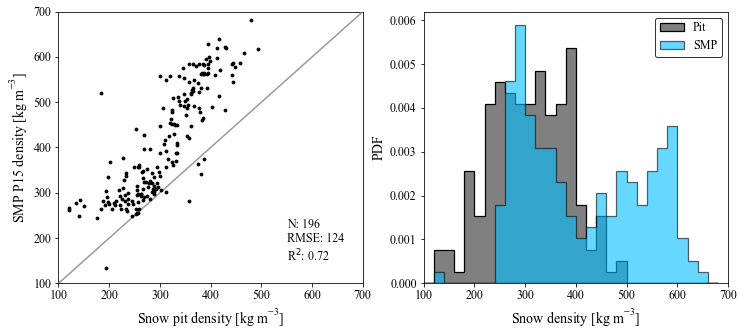

In [8]:
# Paper figure 4 (Top) with caption
# 'Evaluation of the SMP density model parametrization of Proksch et al. (2015) (P15; Top) 
#  and recalibrated coefficients for snow on sea ice (K19b; Bottom). 
#  In both cases the model is evaluated against manual density cutter measurements of snow density.'
axis_value_size = 12
axis_label_size = 14

line_start = 100
line_end = 700
point_size = 8

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(12,5))
ax1.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax2.tick_params(axis='both', which='major', labelsize=axis_value_size)

ax1.scatter(result['RHO'], result['mean_samp'], 
            s = point_size, color ='black', zorder = 1000)
ax1.plot([line_start, line_end], [line_start, line_end], 
         'k-', color = 'gray' ,alpha= 0.8, zorder = 500)

ax1.set_xlim(line_start,line_end)
ax1.set_ylim(line_start,line_end)

rho_bin_size = 20 #in kg m-3
common_bin = np.arange(line_start,line_end, rho_bin_size)
hist_kws = dict(density=True, bins=common_bin, histtype="stepfilled", linewidth=1.25)

ax2.hist(result['RHO'], alpha = 1, edgecolor="black", 
         color = 'grey', label = 'Pit', **hist_kws)
ax2.hist(result['mean_samp'], alpha = 0.6, edgecolor="black", 
         color = 'deepskyblue', label = 'SMP', **hist_kws)

ax1.text(550, 150,'N: %i \nRMSE: %i \nR$^2$: %0.2f'%(p2015_n, p2015_rmse, p2015_r2),  fontsize=12)
ax1.set_ylabel('SMP P15 density [kg m$\mathregular{^{-3}}$]', fontsize=axis_label_size)
ax1.set_xlabel('Snow pit density [kg m$\mathregular{^{-3}}$]', fontsize=axis_label_size)
ax2.set_ylabel('PDF', fontsize=axis_label_size)
ax2.set_xlabel('Snow density [kg m$\mathregular{^{-3}}$]', fontsize=axis_label_size)
ax2.legend(edgecolor = 'black',  fontsize=axis_value_size)
ax2.set_xlim(line_start,line_end)

f.savefig('./output/figures/Fig4_P15Eval_LowQuality.png', format='png')

In [9]:
# Error as a % of mean density
rmse(result.error)/ result['RHO'].mean()

0.4052696591602384

In [10]:
# RMSE by layer type
result.groupby('TYPE')['error'].apply(rmse)

TYPE
F    134.870551
H     95.622354
R    165.192983
Name: error, dtype: float64

In [11]:
# Errors by campaign (a = alert, e = eureka)
campaign_tag = []
ice_tag = []
lat_tag = []
lon_tag = []
for x in result['ID']:
    ice_tag.append(np.asarray(pit_summary[pit_summary['ID']== x]['ICE'].values))
    campaign_tag.append(np.asarray(pit_summary[pit_summary['ID']== x]['IOP'].values))
    lat_tag.append(np.asarray(pit_summary[pit_summary['ID']== x]['LAT'].values))
    lon_tag.append(np.asarray(pit_summary[pit_summary['ID']== x]['LON'].values))

result['campaign'] = np.hstack(campaign_tag)
result['ice_type'] = np.hstack(ice_tag)
result['lat'] = np.hstack(lat_tag)
result['long'] = np.hstack(lon_tag)

result.groupby('campaign')['error'].apply(rmse)

campaign
a     97.933150
e    134.927592
Name: error, dtype: float64

In [12]:
# Errors by ice type (f = fyi, m = myi)
result.groupby('ice_type')['error'].apply(rmse)

ice_type
f    153.150085
m     86.272081
Name: error, dtype: float64

In [13]:
# Export the dataset
result.to_pickle("./output/smp_pit_filtered.pkl")